In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from matplotlib.lines import Line2D

# Data Input and Analysis

## Boundaries

In [2]:
London = gpd.read_file("boundaries/london_boundary/London_GLA_Boundary.shp")
LAD = gpd.read_file("boundaries/Local_Authority_Districts_December_2024_Boundaries_UK_BFC_-5800161498345042609.gpkg")
LAD = LAD[LAD["LAD24CD"].str.startswith("E09")]
len(LAD["LAD24NM"].unique())
LAD['lad_area_m2'] = LAD.geometry.area
LAD.head()

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,lad_area_m2
263,E09000001,City of London,,532382,181358,-0.093520,51.515640,{B9DB852A-88ED-40DC-982B-E815F889D4D4},"MULTIPOLYGON (((532140.296 182191.897, 532139....",2.889680e+06
264,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545559,{241C4B7C-CC36-480A-9C1E-CAD6D53BA5ED},"MULTIPOLYGON (((548881.785 190816.665, 548884....",3.610139e+07
265,E09000003,Barnet,,523473,191752,-0.218200,51.611069,{6D2E9D28-5BAB-4B74-BF81-81EB659210A3},"MULTIPOLYGON (((524579.897 198355.201, 524562....",8.676704e+07
266,E09000004,Bexley,,549202,175434,0.146212,51.458229,{B95765FD-8BDD-4336-ADCC-3F42E1F22960},"MULTIPOLYGON (((547869.85 181500, 547841.35 18...",6.057222e+07
267,E09000005,Brent,,519615,186465,-0.275690,51.564388,{22605C91-A88B-4290-8369-A17751CCF8EB},"MULTIPOLYGON (((520278.817 190250.43, 520265.2...",4.323637e+07


In [3]:
lsoa = gpd.read_file('lsoa_data.gpkg')

lsoa_ = lsoa[['lsoa_2021_code','geometry']]
lsoa_['id'] = [str(i) for i in range(len(lsoa_))]
lsoa_['id'] = lsoa_['id'].astype(int)

lsoa_data = pd.read_csv('lsoa.csv')
lsoa_ = lsoa_.merge(lsoa_data, left_on = 'lsoa_2021_code',right_on ='LSOA 2021 Code', how = "left")
lsoa_.info()
lsoa_.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   lsoa_2021_code       4994 non-null   object  
 1   geometry             4994 non-null   geometry
 2   id                   4994 non-null   int64   
 3   LSOA 2021 Code       4994 non-null   object  
 4   LSOA 2021 Name       4994 non-null   object  
 5   Total_residents      4994 non-null   int64   
 6   female%              4994 non-null   float64 
 7   children%            4994 non-null   float64 
 8   elder%               4994 non-null   float64 
 9   minority_groups%     4994 non-null   float64 
 10  Buddhist%            4994 non-null   float64 
 11  Hindu%               4994 non-null   float64 
 12  Jewish%              4994 non-null   float64 
 13  Muslim%              4994 non-null   float64 
 14  Sikh%                4994 non-null   float64 
 15  Other religio

/Users/yujiama/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yujiama/anaconda3/envs/urbsim/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,lsoa_2021_code,geometry,id,LSOA 2021 Code,LSOA 2021 Name,Total_residents,female%,children%,elder%,minority_groups%,...,Sikh%,Other religion%,No_religion%,bad_heath%,disabled%,speakEng_notwell%,rent%,unemployed%,pop_density,total_open_space_m2
0,E01000001,"MULTIPOLYGON (((532151.538 181867.433, 532152....",0,E01000001,City of London 001A,1795,46.508475,8.018868,25.067385,44.195519,...,0.000000,0.338983,48.338983,1.903467,10.340136,0.345543,42.467378,2.581121,0.013822,32551
1,E01000002,"MULTIPOLYGON (((532634.497 181926.016, 532632....",1,E01000002,City of London 001B,1671,43.858382,5.716353,20.115774,46.893064,...,0.000000,0.361272,49.132948,2.244750,10.613718,0.366569,47.393939,2.459646,0.007315,40268
2,E01000003,"MULTIPOLYGON (((532153.703 182165.155, 532158....",2,E01000003,City of London 001C,1896,46.807192,6.679035,17.748918,49.440299,...,0.185989,0.371978,47.985121,3.041589,13.639182,0.821226,62.857143,4.521277,0.032106,27272
3,E01000005,"MULTIPOLYGON (((533619.062 181402.364, 533639....",3,E01000005,City of London 001E,1737,49.545455,11.748634,9.471767,76.539855,...,0.000000,0.544465,22.141561,7.259528,17.122040,6.647940,91.286307,6.120332,0.009162,22753
4,E01032739,"MULTIPOLYGON (((533376.156 181863.888, 533372....",4,E01032739,City of London 001F,2548,39.345275,4.277743,3.843769,65.228113,...,0.370142,1.480568,43.244911,1.607916,7.204433,1.740211,75.170068,2.910737,0.001549,21407868


## POS data and data analysis

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SiteName    4369 non-null   object  
 1   SiteID      4369 non-null   object  
 2   PrimaryUse  4368 non-null   object  
 3   Borough     4369 non-null   object  
 4   AreaHa      4369 non-null   float64 
 5   Easting     4369 non-null   int64   
 6   Northing    4369 non-null   int64   
 7   Qualifier   4369 non-null   object  
 8   Access      4369 non-null   object  
 9   DataSource  4369 non-null   object  
 10  DataVersio  4369 non-null   object  
 11  ReleaseDat  4369 non-null   object  
 12  Copyright   4369 non-null   object  
 13  geometry    4369 non-null   geometry
dtypes: float64(1), geometry(1), int64(2), object(10)
memory usage: 478.0+ KB


<Axes: >

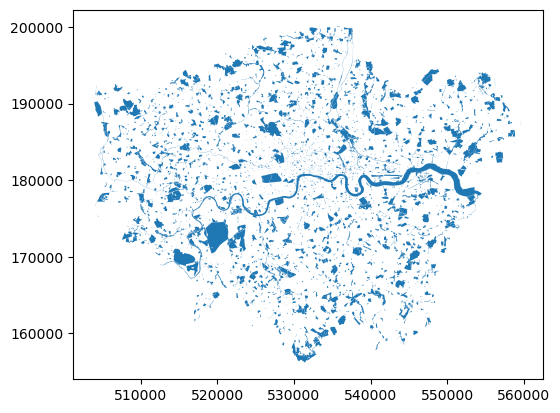

In [4]:
ops_gdf = gpd.read_file("POS_Accessibility/GiGL_SpacesToVisit_Shp/GiGL_SpacesToVisit_region.shp")
ops_gdf.info()
ops_gdf.plot()

In [5]:
# calculate the area of the ops
ops_gdf["area_m2"] = ops_gdf["AreaHa"] * 10000
ops_gdf.head()

,SiteName,SiteID,PrimaryUse,Borough,AreaHa,Easting,Northing,Qualifier,Access,DataSource,DataVersio,ReleaseDat,Copyright,geometry,area_m2
0,Warley Street Drain,OS_Hv_0855,River,Havering,0.7073,559598,187386,Centroid,De facto,Data source: various,15,April 2024,Created by Greenspace Information for Greater ...,"POLYGON ((559600.2 187076.099, 559598.098 1870...",7073.0
1,Thames Chase Community Forest East,OS_Hv_0045,Other recreational,Havering,16.3096,558721,186006,Centroid,Free,Data source: various,15,April 2024,Created by Greenspace Information for Greater ...,"POLYGON ((558522.002 185684.498, 558523.601 18...",163096.0
2,St Mary Magdelane Churchyard,OS_Hv_0454,Cemetery/churchyard,Havering,0.3232,558748,184864,Centroid,Free,Data source: various,15,April 2024,Created by Greenspace Information for Greater ...,"POLYGON ((558804.403 184872.6, 558798.599 1848...",3232.0
3,Macon Way Open Space,OS_Hv_0295,Amenity green space,Havering,0.4298,557519,188024,Centroid,Free,Data source: various,15,April 2024,Created by Greenspace Information for Greater ...,"MULTIPOLYGON (((557507.043 188087.25, 557508.8...",4298.0
4,Cranham Church,OS_Hv_0658,Cemetery/churchyard,Havering,0.3392,557198,186155,Centroid,Free,Data source: various,15,April 2024,Created by Greenspace Information for Greater ...,"POLYGON ((557229.803 186181.495, 557230.396 18...",3392.0


### LAD-level Public Open Space Analysis

In [6]:
# calculate the area of the open space in each LAD
# do the spatail join 
open_space_with_LAD = gpd.overlay(ops_gdf, LAD, how='intersection')
# calculate the area of open space in each borough
lad_open_space_area = open_space_with_LAD.groupby('LAD24NM')['area_m2'].sum().reset_index() 
lad_open_space_area.rename(columns={'area_m2': 'total_open_space_m2'}, inplace=True)

# merge back to LAD 
LAD_ops = LAD.merge(lad_open_space_area, on='LAD24NM', how='left') 
LAD_ops['total_open_space_m2'] = LAD_ops['total_open_space_m2'].fillna(0)

# calculate the open space ratio in each LAD
LAD_ops['open_space_ratio'] = LAD_ops['total_open_space_m2'] / LAD_ops['lad_area_m2']
LAD_ops['open_space_ratio'] = LAD_ops['open_space_ratio'].fillna(0)
LAD_ops.head()

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,lad_area_m2,total_open_space_m2,open_space_ratio
0,E09000001,City of London,,532382,181358,-0.093520,51.515640,{B9DB852A-88ED-40DC-982B-E815F889D4D4},"MULTIPOLYGON (((532140.296 182191.897, 532139....",2.889680e+06,21515192.0,7.445529
1,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545559,{241C4B7C-CC36-480A-9C1E-CAD6D53BA5ED},"MULTIPOLYGON (((548881.785 190816.665, 548884....",3.610139e+07,28228924.0,0.781935
2,E09000003,Barnet,,523473,191752,-0.218200,51.611069,{6D2E9D28-5BAB-4B74-BF81-81EB659210A3},"MULTIPOLYGON (((524579.897 198355.201, 524562....",8.676704e+07,17261662.0,0.198943
3,E09000004,Bexley,,549202,175434,0.146212,51.458229,{B95765FD-8BDD-4336-ADCC-3F42E1F22960},"MULTIPOLYGON (((547869.85 181500, 547841.35 18...",6.057222e+07,33053817.0,0.545693
4,E09000005,Brent,,519615,186465,-0.275690,51.564388,{22605C91-A88B-4290-8369-A17751CCF8EB},"MULTIPOLYGON (((520278.817 190250.43, 520265.2...",4.323637e+07,7590599.0,0.175561


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def add_north_arrow(ax, bounds, scale_width=0.02, scale_height=0.05, fontsize=14, x_offset=0.95, y_offset=0.05):
    # calculate the position of the north arrow
    x = bounds[0] + (bounds[2] - bounds[0]) * x_offset
    y = bounds[3] - (bounds[3] - bounds[1]) * y_offset
    
    # calculate the size of the north arrow
    map_width = bounds[2] - bounds[0]
    map_height = bounds[3] - bounds[1]
    width = map_width * scale_width
    height = map_height * scale_height
    
    # create the shape of the north arrow
    vertices = [
        (x, y),  # start point
        (x - width/2, y - height),  # left bottom
        (x + width/2, y - height),  # right bottom
        (x, y)  # back to the start point
    ]
    codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
    path = Path(vertices, codes)
    
    # draw the north arrow
    arrow = PathPatch(path, facecolor='black', edgecolor='black')
    ax.add_patch(arrow)
    
    # add the "N" label
    plt.text(x, y + height/4, 'N', 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=fontsize,
             fontweight='bold')

def add_scalebar(ax, bounds, length=5, label=None,
                 bar_height_ratio=0.01,
                 x_offset=0.95, y_offset=0.1,
                 color="black", lw=2, fontsize=10):
    if label is None:
        label = f"{length}"
    xmin, ymin, xmax, ymax = bounds
    map_width = xmax - xmin
    map_height = ymax - ymin
    
    # left end point
    x0 = xmin + map_width * x_offset
    y0 = ymin + map_height * y_offset
    
    # line height
    bar_height = map_height * bar_height_ratio
    
    # draw the horizontal line
    ax.plot([x0, x0 + length], [y0, y0], color=color, lw=lw, solid_capstyle='butt')
    # left and right vertical lines
    ax.plot([x0, x0], [y0, y0 + bar_height], color=color, lw=lw)
    ax.plot([x0 + length, x0 + length], [y0, y0 + bar_height], color=color, lw=lw)
    
    # put the text above the line in the center
    ax.text(x0 + length / 2, y0 + bar_height * 2,
            label, ha='center', va='bottom',
            fontsize=fontsize, color=color, weight='bold')

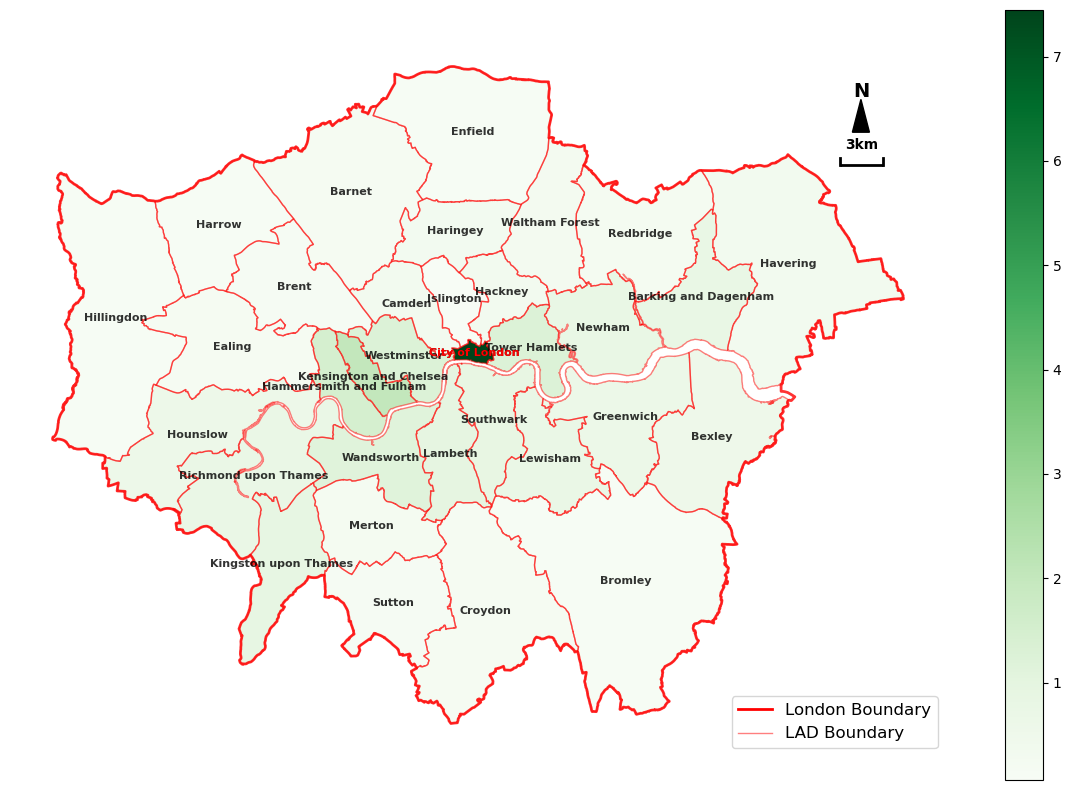

In [8]:
# plot the open space ratio in each LAD
fig, ax = plt.subplots(1,1,figsize=(12, 8))

LAD_ops.plot(column='open_space_ratio', cmap='Greens', legend=True, ax=ax)

for idx, row in LAD.iterrows():
    centroid = row.geometry.centroid
    plt.text(centroid.x, centroid.y, 
             row['LAD24NM'],
             fontsize=8,
             ha='center', 
             va='center',
             fontweight='bold',
             color='black',
             alpha=0.8)
# 为City of London设置特殊文字颜色
for idx, row in LAD.iterrows():
    if row['LAD24NM'] == 'City of London':
        centroid = row.geometry.centroid
        plt.text(centroid.x, centroid.y, 
                row['LAD24NM'],
                fontsize=8,
                ha='center', 
                va='center', 
                fontweight='bold',
                color='red',
                alpha=1)

LAD.plot(ax=ax, edgecolor='red', linewidth = 1, alpha=0.5, facecolor='none')
London.plot(edgecolor='red', linewidth = 2,alpha=0.8, facecolor='none',ax=ax)

legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='London Boundary'),
    Line2D([0], [0], color='red', linewidth=1, alpha=0.5, label='LAD Boundary')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

ax.set_axis_off() 

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
                 x_offset=0.925, y_offset=0.85)

#plt.title('Open Space Ratio of Each Borough in London', fontsize=16)
plt.tight_layout()
plt.savefig("pics/lad_green_proportion.png",dpi=300)
plt.show()

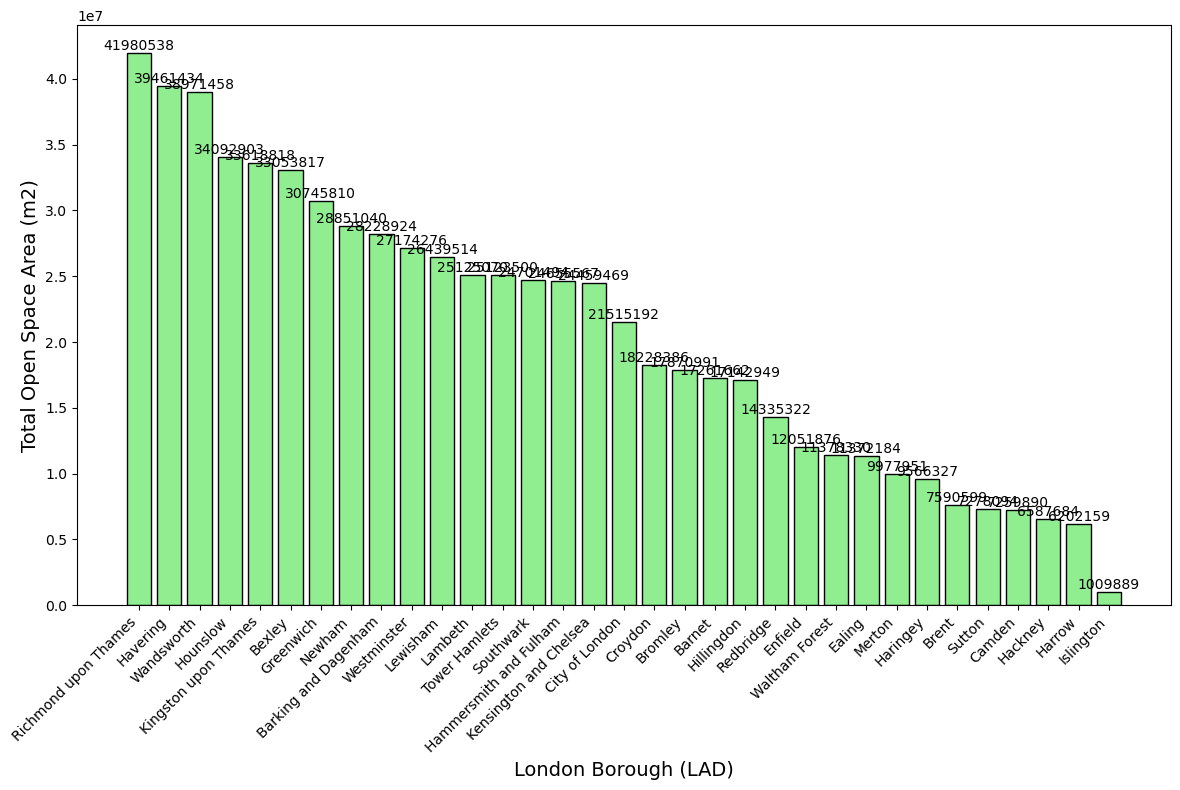

In [9]:
# rank them by area
LAD_ops_sorted = LAD_ops.sort_values('total_open_space_m2', ascending=False)

plt.figure(figsize=(12, 8))
bars_area = plt.bar(LAD_ops_sorted['LAD24NM'], LAD_ops_sorted['total_open_space_m2'], color='lightgreen', edgecolor='black')

for bar in bars_area:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5,
             str(int(height)), ha='center', va='bottom', fontsize=10)

#plt.title('Total Open Space Area of Each Borough in London', fontsize=14)
plt.xlabel('London Borough (LAD)', fontsize=14)
plt.ylabel('Total Open Space Area (m2)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig("pics/lad_ops_area.png",dpi=300)
plt.show()

### LSOA-level POS Analysis

In [10]:
# do the spatail join 
open_space_with_Lsoa = gpd.overlay(ops_gdf, lsoa, how='intersection')
# calculate the area of open space in each lsoa(lowwest super output area)
lsoa_open_space_area = open_space_with_Lsoa.groupby('lsoa_2021_name')['area_m2'].sum().reset_index() 
lsoa_open_space_area.rename(columns={'area_m2': 'total_open_space_m2'}, inplace=True)
# merge back to lsoa 
lsoa_ops = lsoa.merge(lsoa_open_space_area, on='lsoa_2021_name', how='left')
lsoa_ops['total_open_space_m2'] = lsoa_ops['total_open_space_m2'].fillna(0)
lsoa_ops['open_space%'] = lsoa_ops['total_open_space_m2'] / (lsoa_ops['Shape__Are_x'] *10000)
lsoa_ops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   lad_2021_code            4994 non-null   object  
 1   lad_2021_name            4994 non-null   object  
 2   lsoa_2021_code           4994 non-null   object  
 3   lsoa_2021_name           4994 non-null   object  
 4   total_residents          4994 non-null   int32   
 5   children                 4994 non-null   float64 
 6   elder                    4994 non-null   float64 
 7   live_in_flat             4994 non-null   float64 
 8   no_car                   4994 non-null   float64 
 9   disabled                 4994 non-null   float64 
 10  live_far_from_workplace  4994 non-null   float64 
 11  econ_inactive            4994 non-null   float64 
 12  white                    4994 non-null   float64 
 13  mixed                    4994 non-null   float64 
 14  

In [11]:
lsoa_ops_ = lsoa_ops[['lsoa_2021_name','pop_den','total_open_space_m2','open_space%']]
#lsoa_ops_.to_csv('lsoa_ops.csv', index=False)

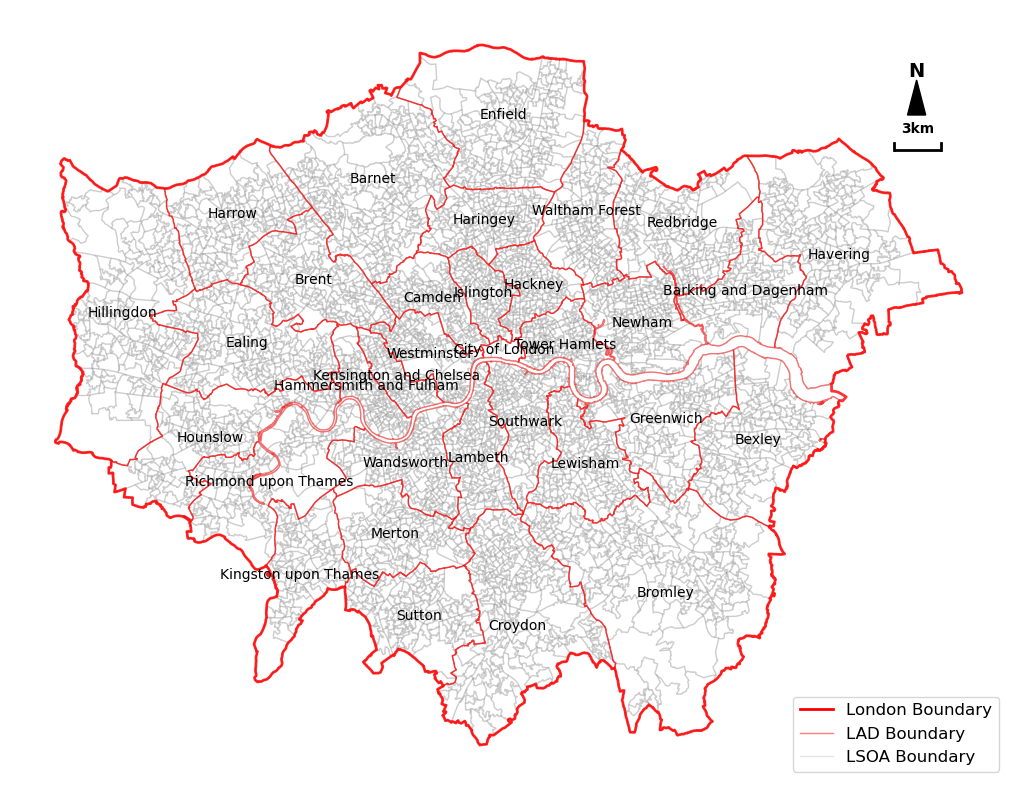

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8)) 

lsoa_ops.plot(edgecolor='black', linewidth = 1,alpha=0.1, facecolor='none',ax=ax)
LAD.plot(edgecolor='red', linewidth = 1, alpha=0.5, facecolor='none',ax=ax)
London.plot(edgecolor='red', linewidth = 2,alpha=0.8, facecolor='none',ax=ax)
# add the label for each LAD
for idx, row in LAD.iterrows():
    centroid = row.geometry.centroid
    plt.text(centroid.x, centroid.y, 
             row['LAD24NM'],
             fontsize=10,
             ha='center', 
             va='center',
             alpha=1)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='London Boundary'),
    Line2D([0], [0], color='red', linewidth=1, alpha=0.5, label='LAD Boundary'),
    Line2D([0], [0], color='black', linewidth=1, alpha=0.1, label='LSOA Boundary')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
                 x_offset=0.925, y_offset=0.85)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig("pics/London_studyarea.png",dpi=300)   
plt.show()

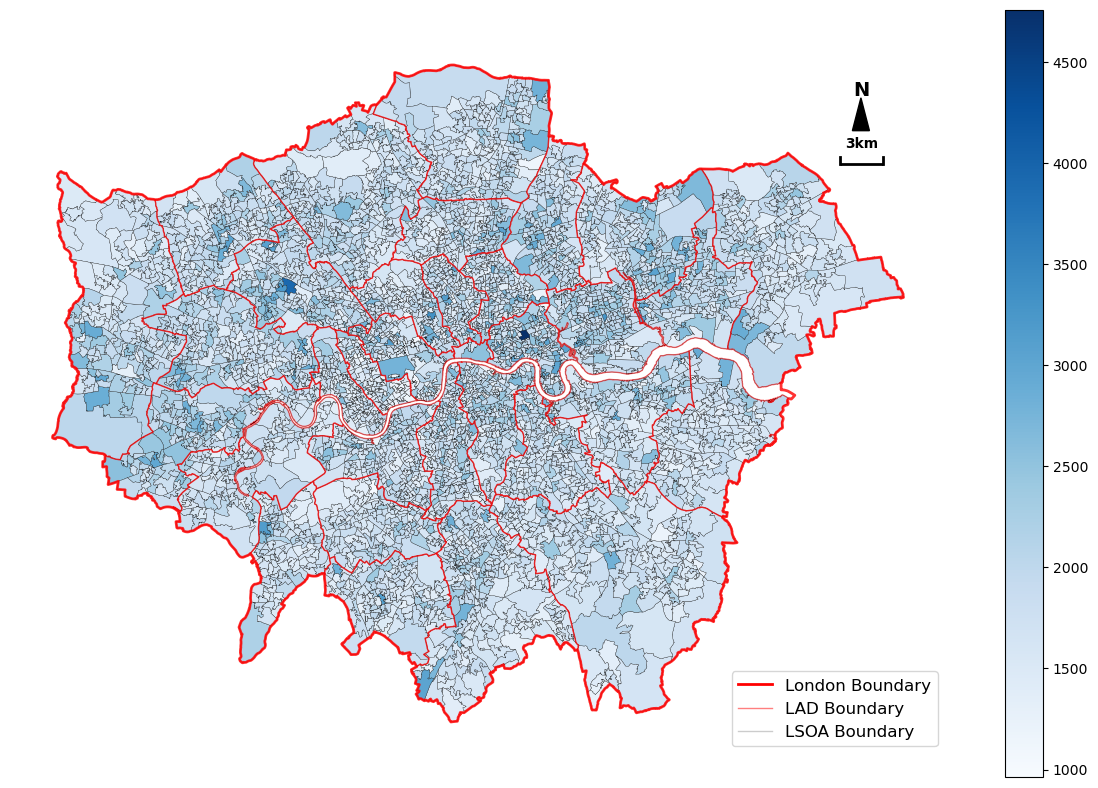

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8)) 
lsoa_ops.plot(
    column='total_residents',
    cmap='Blues',
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax)
LAD.plot(ax=ax, edgecolor='red', linewidth = 1,alpha=0.5, facecolor='none')
London.plot(edgecolor='red', linewidth = 2,alpha=0.8, facecolor='none',ax=ax)

legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='London Boundary'),
    Line2D([0], [0], color='red', linewidth=1, alpha=0.5, label='LAD Boundary'),
    Line2D([0], [0], color='black', linewidth=1, alpha=0.2, label='LSOA Boundary')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
                 x_offset=0.925, y_offset=0.85)

ax.set_axis_off()
#ax.set_title("The Total Residents by LSOA", fontsize=14)

plt.tight_layout()
plt.savefig("pics/lsoa_residents.png",dpi=300)   
plt.show()

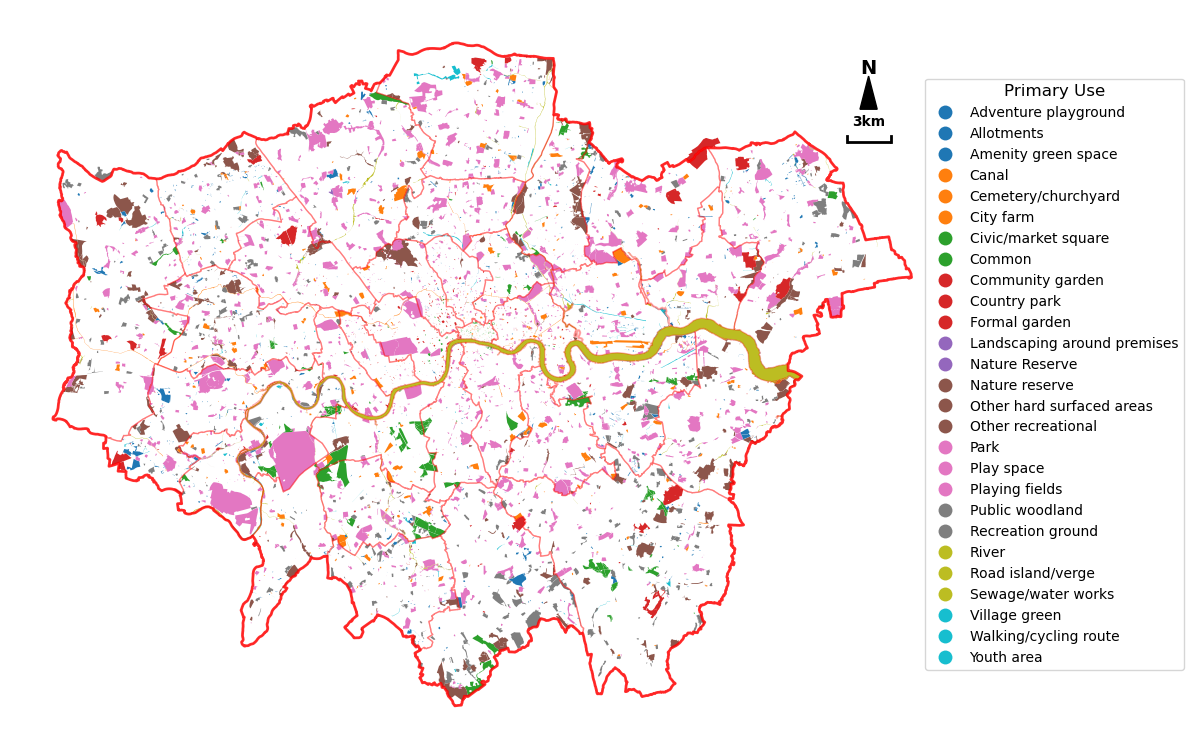

In [14]:
fig, ax = plt.subplots(figsize=(12,10))

ops_gdf.plot(column='PrimaryUse', 
            ax=ax, 
            legend=True,
            markersize=30,
            alpha=1,
            categorical=True,
            legend_kwds={'bbox_to_anchor': (1.25, 0.5),
             'loc': 'center right',
                          'fontsize': 10,
                          'title': 'Primary Use',
                          'title_fontsize': 12})
LAD.plot(ax=ax, edgecolor='red', linewidth=1, alpha=0.3, facecolor='none')
London.plot(edgecolor='red', linewidth = 2,alpha=0.8, facecolor='none',ax=ax)

add_north_arrow(ax, LAD.total_bounds)
add_scalebar(ax, LAD.total_bounds,length=3000, label="3km", bar_height_ratio=0.01,
                 x_offset=0.925, y_offset=0.85)

#ax.set_title('Open Space Distribution in London', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("pics/distribution_of_openspace_by_use.png",dpi=300) 
plt.show()

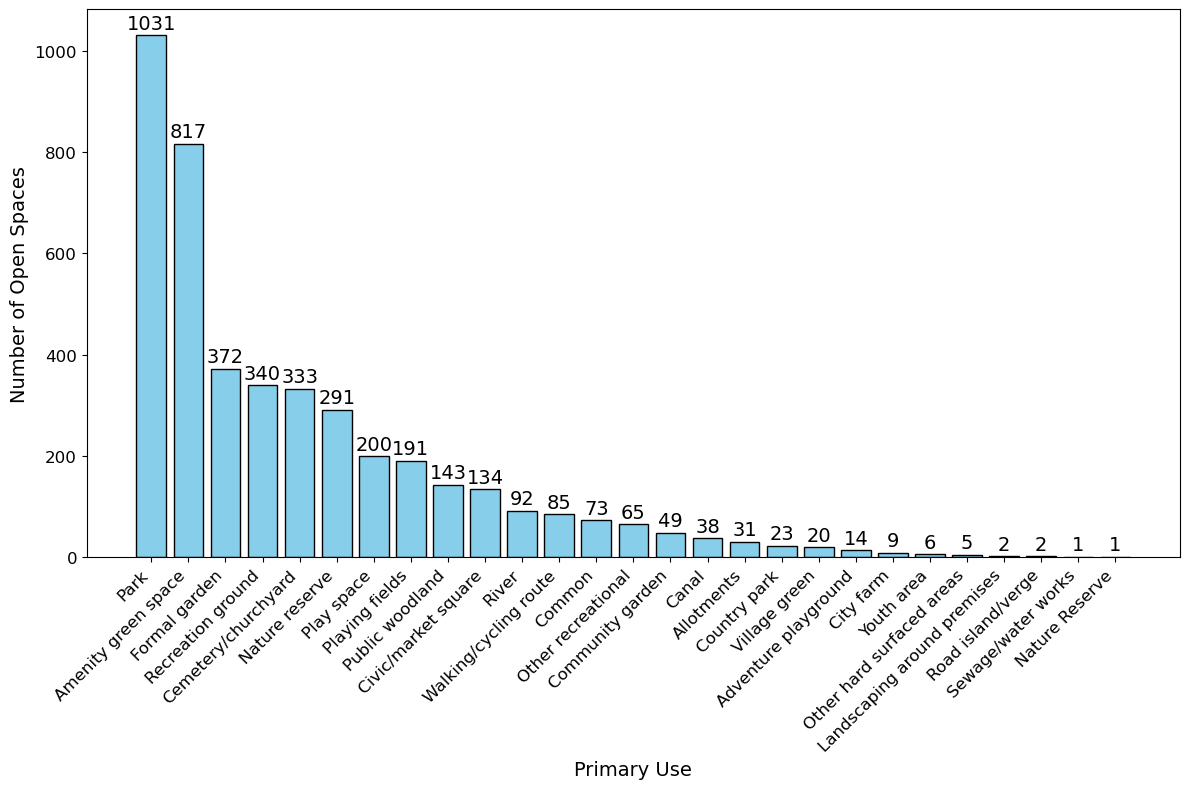

In [15]:
use_counts = ops_gdf['PrimaryUse'].value_counts()

plt.figure(figsize=(12, 8))
bars_use = plt.bar(use_counts.index, use_counts.values, 
               color='skyblue', edgecolor='black')

for bar in bars_use:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
             str(int(height)), ha='center', va='bottom', fontsize=14)

#plt.title('Count of OpenSpace by Primary Use in London', fontsize=14)
plt.xlabel('Primary Use', fontsize=14)
plt.ylabel('Number of Open Spaces', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig("pics/openspace_by_use.png",dpi=300) 
plt.show()

# Census 2021 Data 

## select variables

In [17]:
lsoa_.columns

Index(['lsoa_2021_code', 'geometry', 'id', 'LSOA 2021 Code', 'LSOA 2021 Name',
       'Total_residents', 'female%', 'children%', 'elder%', 'minority_groups%',
       'Buddhist%', 'Hindu%', 'Jewish%', 'Muslim%', 'Sikh%', 'Other religion%',
       'No_religion%', 'bad_heath%', 'disabled%', 'speakEng_notwell%', 'rent%',
       'unemployed%', 'pop_density', 'total_open_space_m2'],
      dtype='object')

### visualisation of variables

In [ ]:
# 选择要绘制的指标
indicators = ['female%', 'children%', 'elder%', 'minority_groups%',
       'Buddhist%', 'Hindu%', 'Jewish%', 'Muslim%', 'Sikh%', 'Other religion%',
       'No_religion%', 'bad_heath%', 'disabled%', 'no_qualification%',
       'speakEng_notwell%', 'rent%', 'unemployed%', 'pop_density',
       'total_open_space_m2']

In [ ]:
for idx, indicator in enumerate(indicators):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    vmin, vmax = lsoa_[indicator].quantile([0.05, 0.95])
    breaks = np.linspace(vmin, vmax, 6)
    
    lsoa_.plot(column=indicator,
              ax=ax, 
              cmap='Oranges',
              legend=True,
              scheme='user_defined',
              classification_kwds={'bins': breaks},
              legend_kwds={'title': indicator,
                         'loc': 'lower left',
                         'bbox_to_anchor': (1.0, 0.5),
                         'fontsize': 8})
    LAD.plot(ax=ax, edgecolor='red', linewidth = 0.8, alpha=0.5, facecolor='none')
    London.plot(edgecolor='red', linewidth = 1, alpha=0.8, facecolor='none',ax=ax)
    
    add_north_arrow(ax, lsoa_.total_bounds, fontsize=8)
    add_scalebar(ax, lsoa_.total_bounds, length=3000, label="3km", bar_height_ratio=0.01,
                x_offset=0.925, y_offset=0.85, lw=1, fontsize=8)
    
    ax.set_title(indicator, fontsize=12)
    ax.axis('off')
    
    plt.tight_layout()
    #plt.savefig(f"pics/{indicator.replace('%','')}.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

In [ ]:
df = lsoa_[['female%', 'children%', 'elder%', 'minority_groups%',
       'Buddhist%', 'Hindu%', 'Jewish%', 'Muslim%', 'Sikh%', 'Other religion%',
       'No_religion%', 'bad_heath%', 'disabled%', 'speakEng_notwell%', 'rent%', 
       'unemployed%', 'pop_density', 'total_open_space_m2']]

In [ ]:
# calculate the descriptive statistics
desc_stats = df.describe()
desc_stats.loc['skew'] = df.skew()
desc_stats.loc['kurtosis'] = df.kurtosis()
print("Descriptive statistics, skew and kurtosis:")
print(desc_stats)

Descriptive statistics, skew and kurtosis:
              female%    children%       elder%  minority_groups%  \
count     4994.000000  4994.000000  4994.000000       4994.000000   
mean        51.534675    17.965091    12.122535         62.235982   
std          2.076084     4.320119     5.476400         18.833607   
min         30.223240     2.952261     0.260191          7.438017   
25%         50.396935    15.493849     8.382425         48.718054   
50%         51.592576    18.044069    11.114080         64.066011   
75%         52.777778    20.546482    15.201052         77.091047   
max         69.704142    41.058655    44.874275         99.457505   
skew        -0.785167     0.002904     0.825408         -0.354942   
kurtosis     7.676638     1.066066     1.062716         -0.601182   

            Buddhist%       Hindu%      Jewish%      Muslim%        Sikh%  \
count     4994.000000  4994.000000  4994.000000  4994.000000  4994.000000   
mean         0.876386     5.009147     1.69

In [ ]:
desc_stats.round(2)
desc_stats_transposed = desc_stats.transpose()
desc_stats_transposed.round(2)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
female%,4994.0,51.53,2.08,30.22,50.40,51.59,52.78,69.70,-0.79,7.68
children%,4994.0,17.97,4.32,2.95,15.49,18.04,20.55,41.06,0.00,1.07
elder%,4994.0,12.12,5.48,0.26,8.38,11.11,15.20,44.87,0.83,1.06
minority_groups%,4994.0,62.24,18.83,7.44,48.72,64.07,77.09,99.46,-0.35,-0.60
Buddhist%,4994.0,0.88,0.68,0.00,0.44,0.75,1.13,12.06,3.28,28.53
Hindu%,4994.0,5.01,6.76,0.00,1.23,2.51,5.77,63.61,3.07,12.27
Jewish%,4994.0,1.69,5.61,0.00,0.12,0.35,0.94,69.09,7.01,57.34
Muslim%,4994.0,14.40,11.78,0.23,5.92,10.97,19.23,72.65,1.63,2.91
Sikh%,4994.0,1.55,4.23,0.00,0.14,0.40,1.02,53.04,6.04,44.40
Other religion%,4994.0,0.98,1.04,0.00,0.42,0.70,1.12,13.83,3.64,20.64
